In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
import scipy.stats as st
import tqdm
import pandas as pd
import os
import matplotlib as mpl
import ligo.skymap.plot
import astropy.units as u
from astropy.coordinates import SkyCoord


%matplotlib notebook


HECATE_PATH = 'hecate_v1.1_for_GW.csv'
SKYMAP_URL = 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar.fits.gz'
SKYMAP_PATH = 'GW170817_skymap.fits.gz'
save = True

In [2]:
def get_candidates(hecate_path, skymap_url=None, skymap_path=None, probability=0.99, outpath=None):
    print("Loading galaxy catalogue...")
    hecate = pd.read_csv(HECATE_PATH)

    print("Downloading/loading GW skymap...")
    if skymap_url is not None:
        assert skymap_path is None
        skymap_filename = download_file(SKYMAP_URL, cache=True, show_progress=True)
    else:
        assert skymap_path is not None
        skymap_filename = skymap_path
    #prob, distmu, distsigma, distnorm = hp.read_map(skymap_filename, field=[0, 1, 2, 3])
    
    # Commented out by KK: fitsFile = '../TP3_/GW170817_skymap.fits.gz'
    # Commented out by KK: [prob, distmu, distsigma, distnorm] = hp.read_map(fitsFile, field=[0, 1, 2, 3]) 

    # Changed by Konstantinos
    [prob, distmu, distsigma, distnorm], header = hp.read_map(skymap_filename, field=[0, 1, 2, 3], h=True) # creates 2 arrays, one with 4 columns, and one for the header column that is needed to find an abstract value which is the NSIDE for the ang2pix function

    
    print("Selecting highest-probability pixels...")
    npixels = len(prob)
    nside = hp.npix2nside(npixels)
    contour_probability = probability
    sorted_indices = np.argsort(prob)
    sorted_probs = prob[sorted_indices]
    assert np.all(sorted_probs >= 0)
    cumulative_prob = np.cumsum(sorted_probs)
    cumulative_prob /= cumulative_prob[-1]
    where_to_cut = np.argmax(cumulative_prob > 1.0 - contour_probability)
    selected_indices = sorted_indices[where_to_cut:]
    print("    Fraction of selected pixels: {:.6g}".format(len(selected_indices) / float(npixels)))

    print("Cross-matching with galaxy catalog...")
    n_galaxies = hecate.shape[0]
    HECATE_pixels = hp.ang2pix(nside, np.asarray(hecate["RA"]), np.asarray(hecate["DEC"]), lonlat=True)
    selected_indices_set = set(selected_indices)
    is_candidate = np.zeros(n_galaxies, dtype=bool)
    for i in tqdm.tqdm(range(n_galaxies)):
        pixel = HECATE_pixels[i]
        is_candidate[i] = (pixel in selected_indices_set)
    candidates = hecate[is_candidate].copy()
    print("    {} selected galaxies".format(len(candidates)))
    
    cand_pixels = HECATE_pixels[is_candidate]
    #prob_cand, distmu_cand, distsigma_cand, distnorm_cand = prob[cand_pixels], distmu[cand_pixels], distsigma[cand_pixels], distnorm[cand_pixels]
    #return candidates, prob_cand, distmu_cand, distsigma_cand, distnorm_cand
    candidates["prob"] = prob[cand_pixels]
    candidates["distmu"] = distmu[cand_pixels]
    candidates["distsigma"] = distsigma[cand_pixels]
    candidates["distnorm"] = distnorm[cand_pixels]
    
    if outpath is not None:
        print("Saving candidates catalog in `{}`".format(outpath))
        candidates.to_csv(outpath)
    return candidates
#get_candidates(HECATE_PATH, skymap_path=SKYMAP_PATH, probability=1.0, outpath=None if not save else "candidates_WISE_SFRs.csv")

Getting WISE SFRs from another file...
Adding to the candidates table


<IPython.core.display.Javascript object>


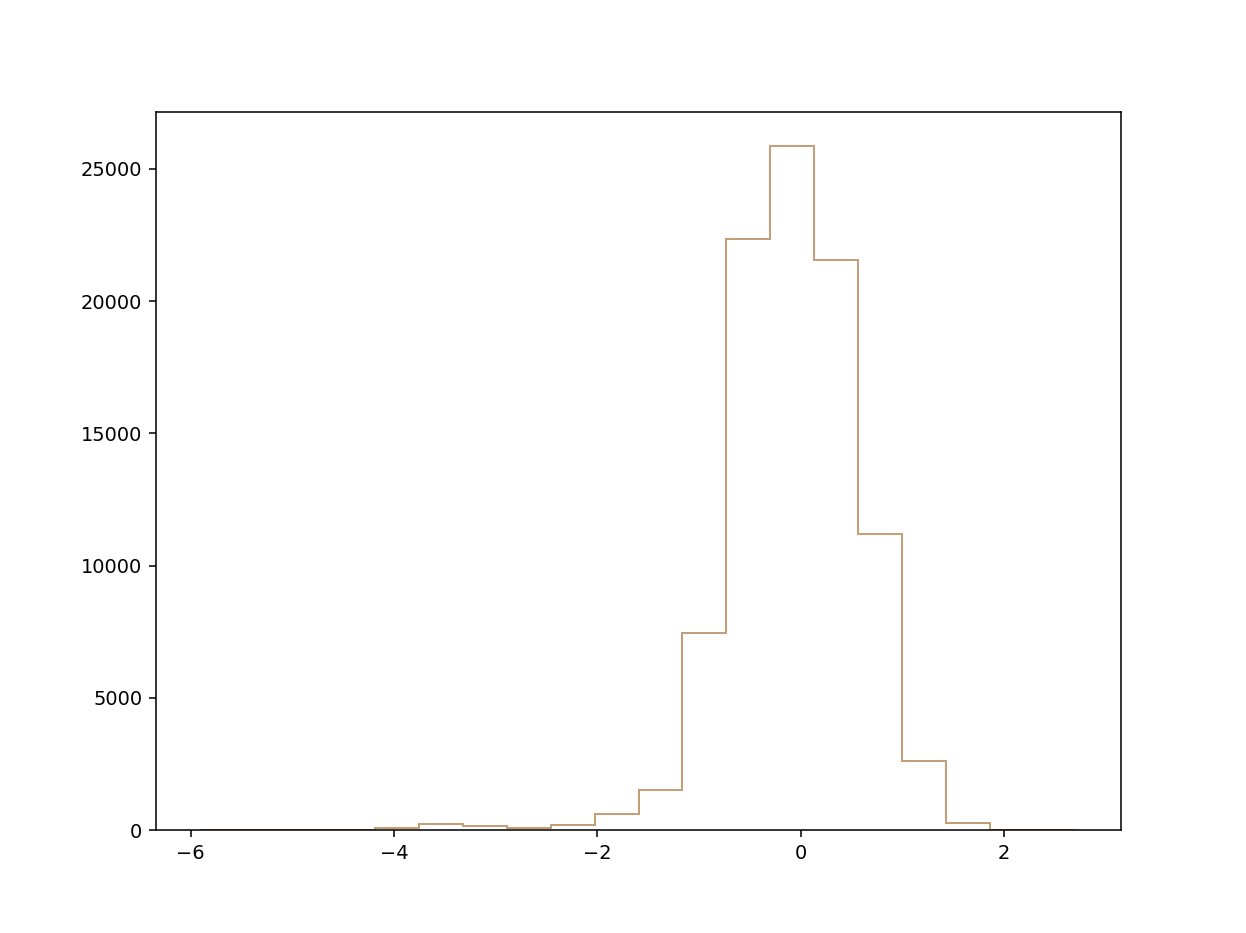

Added 0 WISE SFR estimates, not found 110464 and 94269 already existed


,PGC,OBJNAME,SDSS_PHOTID,RA,DEC,R1,R2,PA,V,D,BT,logSFR_HEC,logM_HEC,logSFR_GSW,logM_GSW,METAL,logSFR
0,2,UGC12889,-,0.006945,47.274581,0.933,0.589,163.5,5016.7,67.9204,14.241,NaN,11.0780,NaN,NaN,NaN,NaN
1,3,PGC000003,-,0.013125,-18.008200,0.330,0.330,0.0,8954.0,124.2548,15.150,0.425,9.5614,NaN,NaN,NaN,0.425
2,4,PGC000004,1237679478544072744,0.014292,23.087596,0.428,0.095,63.2,4461.7,53.9879,16.880,NaN,NaN,NaN,NaN,NaN,NaN
3,5,IC5370,1237663234987458745,0.038121,32.738420,0.391,0.391,0.0,10365.2,146.2144,14.759,0.222,11.3953,NaN,NaN,NaN,0.222
4,6,PGC000006,1237656496724312079,0.008763,15.881670,0.200,0.144,89.6,6003.3,85.6908,15.546,0.227,10.1894,-0.239,9.94,8.7275,0.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204728,6774239,[ONC2011]J239.773773+27.335077,1237662340012638750,239.773773,27.335077,0.056,0.021,128.0,13367.6,185.7535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204729,6774551,[ONC2011]J260.178596+26.546328,1237655473438785924,260.178596,26.546328,0.055,0.019,45.0,4810.8,70.0893,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204730,6774922,[ONC2011]J260.058200+26.600056,1237655473438720341,260.058200,26.600056,0.035,0.035,0.0,13085.3,183.6867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204731,6775370,BST1047+1156,-,161.932500,11.933611,NaN,NaN,NaN,970.0,16.1664,20.110,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Changed by Konstantinos
candidates = pd.read_csv(HECATE_PATH)
EXTRA_WISE_DATA = 'candidates_WISE_SFRs.csv'

WISE_SFRS = True
if WISE_SFRS:
    n_added = 0
    n_existed = 0
    n_notfound = 0
    print("Getting WISE SFRs from another file...")
    #wise_sfrs = pd.read_csv("candidates_WISE_SFRs.csv")
    wise_sfrs = pd.read_csv(EXTRA_WISE_DATA)
    print("Adding to the candidates table")
    # candidates["logSFR"] = np.zeros(len(candidates)) #candidates["logSFR_HEC"].copy()
    new_SFRS = []
    for pgc_i, sfr_i in zip(candidates["PGC"], candidates["logSFR_HEC"]):
        if np.isfinite(sfr_i):
            new_sfr = sfr_i
            n_existed += 1
        else:
            try:
                where = np.where(wise_sfrs["PGC"] == pgc_i)
                where = where[0][0]
                new_sfr = wise_sfrs["logSFR_W"][where]
                n_added += 1
            except:
                new_sfr = np.nan
                n_notfound += 1
        new_SFRS.append(new_sfr)
    candidates["logSFR"] = np.array(new_SFRS)
    plt.figure()
    plt.hist(candidates["logSFR_HEC"], histtype="step", bins=20, alpha=0.5)
    plt.hist(candidates["logSFR"], histtype="step", bins=20, alpha=0.5)
    plt.show()
    print("Added {} WISE SFR estimates, not found {} and {} already existed".format(n_added, n_notfound, n_existed))

candidates

In [4]:
def normalise(x):
    X = np.asarray(x)
    return X / np.nansum(X)

fitsFile = SKYMAP_PATH
[prob, distmu, distsigma, distnorm], header = hp.read_map(fitsFile, field=[0, 1, 2, 3], h = True) # creates 2 arrays, one with 4 columns, and one for the header column that is needed to find an abstract value which is the NSIDE for the ang2pix function
headerDict = {nameKeys:value for nameKeys,value in header} # Creates a dictionnary between a key and a value associated
HECATE_pixelsIndex = hp.ang2pix(headerDict['NSIDE'], candidates['RA'], np.array(candidates['DEC']), lonlat=True) # Converts the 2 angle values we have to pixel values, that we'll then make correspond with the FITS pixels

from gw_tools import apparent_to_L, BNS_merger_rates_M, BNS_merger_rates_MS
P_2d = prob[HECATE_pixelsIndex]
P2D_norm = normalise(P_2d)
# P_3d = P_2d * candidates.distnorm * st.norm(candidates.distmu, candidates.distsigma).pdf(candidates.D)
P_3d = P_2d * distnorm[HECATE_pixelsIndex] * np.exp(-(candidates["D"] - distmu[HECATE_pixelsIndex])**2.0 / (2*distsigma[HECATE_pixelsIndex]**2.0))
print(min(P_3d), max(P_3d))
# P_3d = normalise(P_3d)

0.0 2.0014863123578892e-07


In [5]:
# P3D top 5 sources

P3D_noNan = np.nan_to_num(P_3d)

sumP3D = np.sum(P3D_noNan)

P3D_norm = P3D_noNan/sumP3D # Normalized P3D array

fiveMaxP3DIndex = np.argsort(P3D_norm)[-5:][::-1] 

fiveMaxP3D = P3D_norm[fiveMaxP3DIndex]

fiveMaxP3DNames = candidates['OBJNAME'][fiveMaxP3DIndex]

fiveMaxP3DNames = fiveMaxP3DNames.to_numpy()

print(np.c_[fiveMaxP3DNames, fiveMaxP3D])

[['ESO508-004' 0.09702691660452716]
 ['ESO575-053' 0.08538876969327197]
 ['NGC4993' 0.08403238945297146]
 ['ESO575-055' 0.08214344798589562]
 ['ESO508-024' 0.06778222692654902]]


In [6]:
# Adding all logSFR_W values of the Wise file to a new SFR_final column of the hecate file

def fill_SFR(old, new):
    return new if not np.isfinite(old) else old

wiseFile = np.genfromtxt('candidates_WISE_SFRs.csv', delimiter = "," , names = True)
SFR_additional = wiseFile['logSFR_W']
SFR_original = candidates['logSFR_HEC'].to_numpy()
SFR_final = SFR_original.copy()

for wise_row in wiseFile:
    target_PGC = wise_row['pgc']
    target_logSFR = wise_row['logSFR_W']
    indexHEC = np.where(candidates['PGC'] == target_PGC)[0][0]

    original_logSFR = candidates['logSFR_HEC'][indexHEC]
    updated_logSFR = fill_SFR(original_logSFR, target_logSFR)
    SFR_final[indexHEC] = updated_logSFR

print("# of original SFRs   : ", sum(np.isfinite(SFR_original)))    # sum(booleans) add 1 per true boolean value
print("# of additional SFRs : ", sum(np.isfinite(SFR_additional)))
print("# of final SFRs      : ", sum(np.isfinite(SFR_final)))

# of original SFRs   :  94269
# of additional SFRs :  2130
# of final SFRs      :  96123


In [7]:
# Merger rate parameters : mass 

# constant values from the table 1 of Artale paper at z = 0.1 (redshift very small)
a1 = 1.038
a2 = -6.09

logn_M = a1*candidates['logM_HEC'].to_numpy() + a2 # Column logM_HEC from the csv file to (1) of Artale paper

#logn_M = np.nan_to_num(logn_M) # we don't want to do that because of how we'll code the "complete" function later

PnM = P_3d*np.exp(logn_M) # Using formula (1) of the Artale paper

In [8]:
# P3D*n(M*) top 5 sources

PnM_noNan = np.nan_to_num(PnM)

sumPnM = np.sum(PnM_noNan)

PnM_norm = PnM_noNan/sumPnM # Normalizing

fiveMaxPnMIndex = np.argsort(PnM_norm)[-5:][::-1]

fiveMaxPnM = PnM_norm[fiveMaxPnMIndex]

fiveMaxPnMnames = candidates['OBJNAME'][fiveMaxPnMIndex]

fiveMaxPnMnames = fiveMaxPnMnames.to_numpy()

print(np.c_[fiveMaxPnMnames, fiveMaxPnM])

[['NGC4993' 0.27995863166791]
 ['ESO575-053' 0.1088176694956537]
 ['ESO508-024' 0.1021558875393103]
 ['ESO575-055' 0.08062150453325888]
 ['NGC4968' 0.07418698242706137]]


In [9]:
# Merger rate parameters : SFR

# constant values for formula (2)
b1 = 0.8
b2 = 0.323
b3 = -3.555

logn_MSFR = b1*candidates['logM_HEC'].to_numpy() + b2*SFR_final + b3

PnMSFR = P_3d*np.exp(logn_MSFR) # Using formula (2) of the Artale paper

In [10]:
# P3D*n(M*,SFR) top 5 sources

PnMSFR_noNan = np.nan_to_num(PnMSFR)

sumPnMSFR = np.sum(PnMSFR_noNan)

PnMSFR_norm = PnMSFR_noNan/sumPnMSFR # Normalizing

fiveMaxPnMSFRIndex = np.argsort(PnMSFR_norm)[-5:][::-1]

fiveMaxPnMSFR = PnMSFR_norm[fiveMaxPnMSFRIndex]

fiveMaxPnMSFRnames = candidates['OBJNAME'][fiveMaxPnMSFRIndex]

fiveMaxPnMSFRnames = fiveMaxPnMSFRnames.to_numpy()

print(np.c_[fiveMaxPnMSFRnames, fiveMaxPnMSFR])

[['NGC4993' 0.24999785293107346]
 ['ESO575-053' 0.11501532257306397]
 ['ESO508-024' 0.11194904253350747]
 ['NGC4968' 0.09214261412727676]
 ['ESO575-055' 0.08633991927380752]]


In [11]:
# Merger rate parameters : Z (metallicity)

# Creating the array of metallicity from the values we got from the "METAL" column in hecate
Z_sun = 0.0142
logOH_sun = 8.69 # sun oxygen mass fraction
Z = Z_sun*10**(candidates['METAL'].to_numpy()-logOH_sun) # Z/Z_sun(O/H) = (O/H)/(O/H)_sun

# constant values for formula (3)
c1 = 0.701
c2 = 0.356
c3 = 0.411
c4 = -1.968

logn_MSFRZ = c1*candidates['logM_HEC'].to_numpy() + c2*SFR_final + c3*np.log(Z) + c4

P3D_normed = P_3d/np.nansum(P_3d)

PnZ = P3D_normed*np.exp(logn_MSFRZ - np.nanmin(logn_MSFRZ))

In [12]:
# Now we want to make a function that does the different formulas to compute the probability 
# in function of what column we have available

# The 4 arrays we have are P3D, PnM, PnMSFR, PnMSFRZ

# The idea is : If the value of PnZ is NaN, then replace it by PnMSFR. And do the same until P3D 
# as long as it's NaN.
# Note : We take the non-normalized array for the 4 previous probabilities, and we normalize P_final

P_final = np.array(PnZ)

nan_indexes1 = np.isnan(P_final)
P_final[nan_indexes1] = PnMSFR[nan_indexes1]
nan_indexes2 = np.isnan(P_final)
P_final[nan_indexes2] = PnM[nan_indexes2]
nan_indexes3 = np.isnan(P_final)
P_final[nan_indexes3] = P_3d[nan_indexes3]

P_final = np.nan_to_num(P_final)

sumP_final = np.sum(P_final)

P_final = P_final/sumP_final # Normalized PnAll array

#P_final = np.nan_to_num(P_final)

# print(np.min(P_final))

In [13]:
# P3D*n(M*,SFR, Z) FINAL FORMULA, top 10 sources

tenMaxP_finalIndex = np.argsort(P_final)[-10:][::-1]

tenMaxP_final = P_final[tenMaxP_finalIndex]

tenMaxP_finalnames = candidates['OBJNAME'][tenMaxP_finalIndex]

tenMaxP_finalnames = tenMaxP_finalnames.to_numpy()

print(np.c_[tenMaxP_finalnames, tenMaxP_final])

[['NGC4993' 0.24760245927580468]
 ['ESO575-053' 0.11391328521266246]
 ['ESO508-024' 0.11087638521643799]
 ['NGC4968' 0.09125973521182779]
 ['ESO575-055' 0.08551263978960363]
 ['ESO508-010' 0.05930557923034813]
 ['PGC797164' 0.05063582605799844]
 ['IC4197' 0.04739423284434588]
 ['PGC169673' 0.03727600767732552]
 ['NGC4830' 0.03536703746176899]]


In [14]:
# Results

print("P3D", np.c_[fiveMaxP3DNames, fiveMaxP3D], " "
      , "P3D*n(M*)", np.c_[fiveMaxPnMnames, fiveMaxPnM], " "
      , "P3D*n(M*,SFR)", np.c_[fiveMaxPnMSFRnames, fiveMaxPnMSFR], " "
      , "P3D*n(final)", np.c_[tenMaxP_finalnames, tenMaxP_final],sep='\n')

P3D
[['ESO508-004' 0.09702691660452716]
 ['ESO575-053' 0.08538876969327197]
 ['NGC4993' 0.08403238945297146]
 ['ESO575-055' 0.08214344798589562]
 ['ESO508-024' 0.06778222692654902]]
 
P3D*n(M*)
[['NGC4993' 0.27995863166791]
 ['ESO575-053' 0.1088176694956537]
 ['ESO508-024' 0.1021558875393103]
 ['ESO575-055' 0.08062150453325888]
 ['NGC4968' 0.07418698242706137]]
 
P3D*n(M*,SFR)
[['NGC4993' 0.24999785293107346]
 ['ESO575-053' 0.11501532257306397]
 ['ESO508-024' 0.11194904253350747]
 ['NGC4968' 0.09214261412727676]
 ['ESO575-055' 0.08633991927380752]]
 
P3D*n(final)
[['NGC4993' 0.24760245927580468]
 ['ESO575-053' 0.11391328521266246]
 ['ESO508-024' 0.11087638521643799]
 ['NGC4968' 0.09125973521182779]
 ['ESO575-055' 0.08551263978960363]
 ['ESO508-010' 0.05930557923034813]
 ['PGC797164' 0.05063582605799844]
 ['IC4197' 0.04739423284434588]
 ['PGC169673' 0.03727600767732552]
 ['NGC4830' 0.03536703746176899]]


P2D proba


<IPython.core.display.Javascript object>


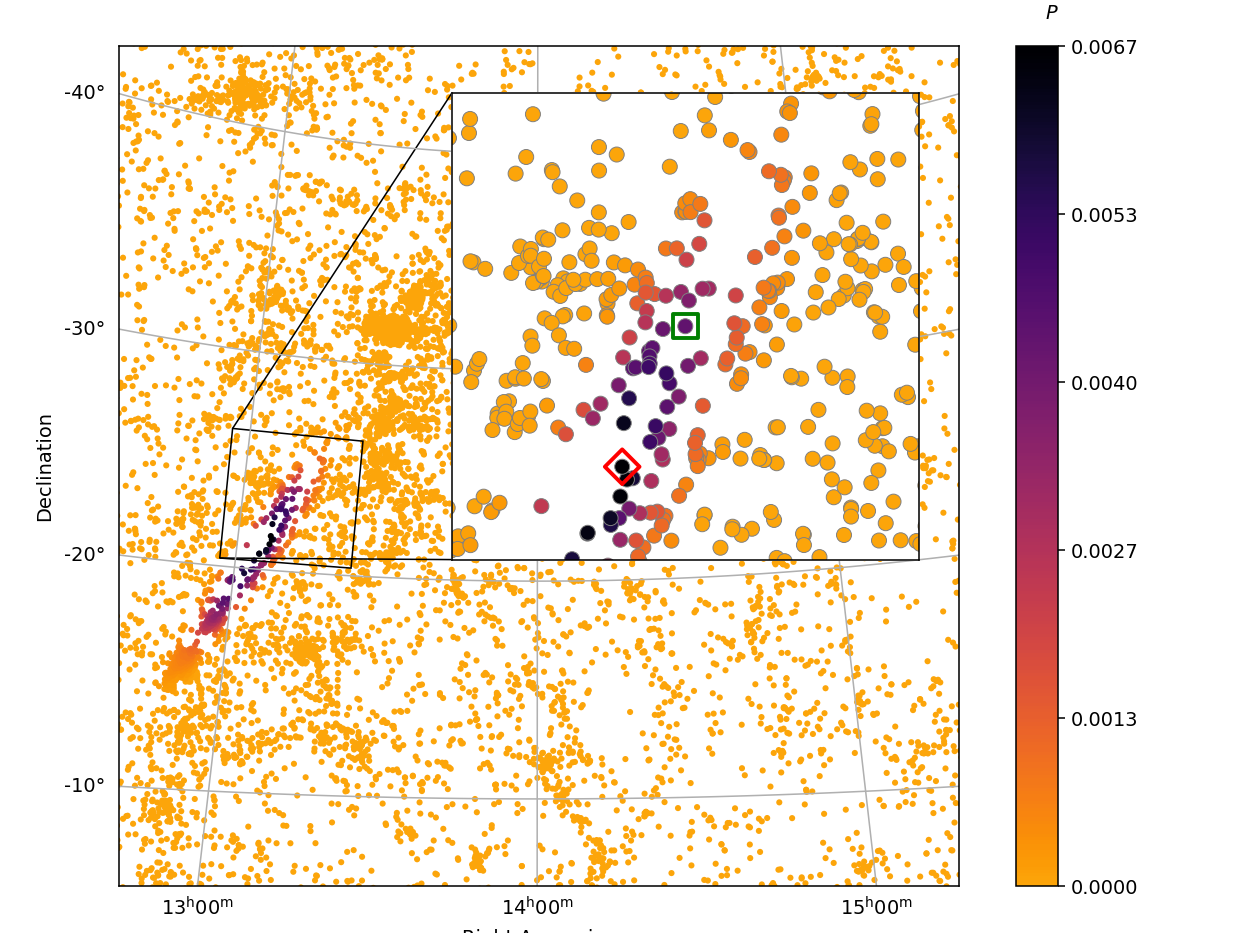

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(196.577,-21.5761)
vmin, vmax = 0.0, 0.006675970091842589

P3D proba


<IPython.core.display.Javascript object>


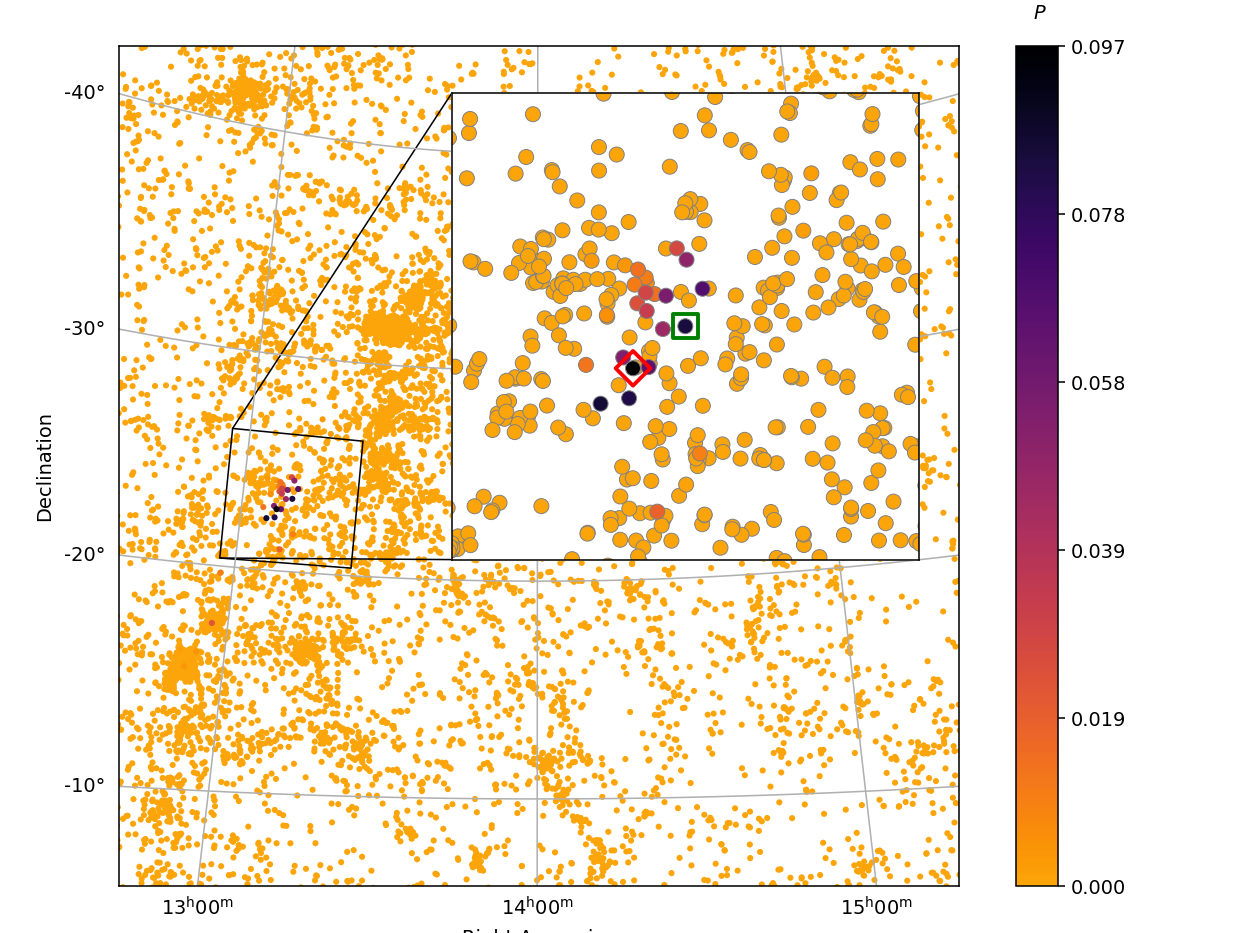

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(196.719,-22.8414)
vmin, vmax = 0.0, 0.09702691660452716

PnM proba


<IPython.core.display.Javascript object>


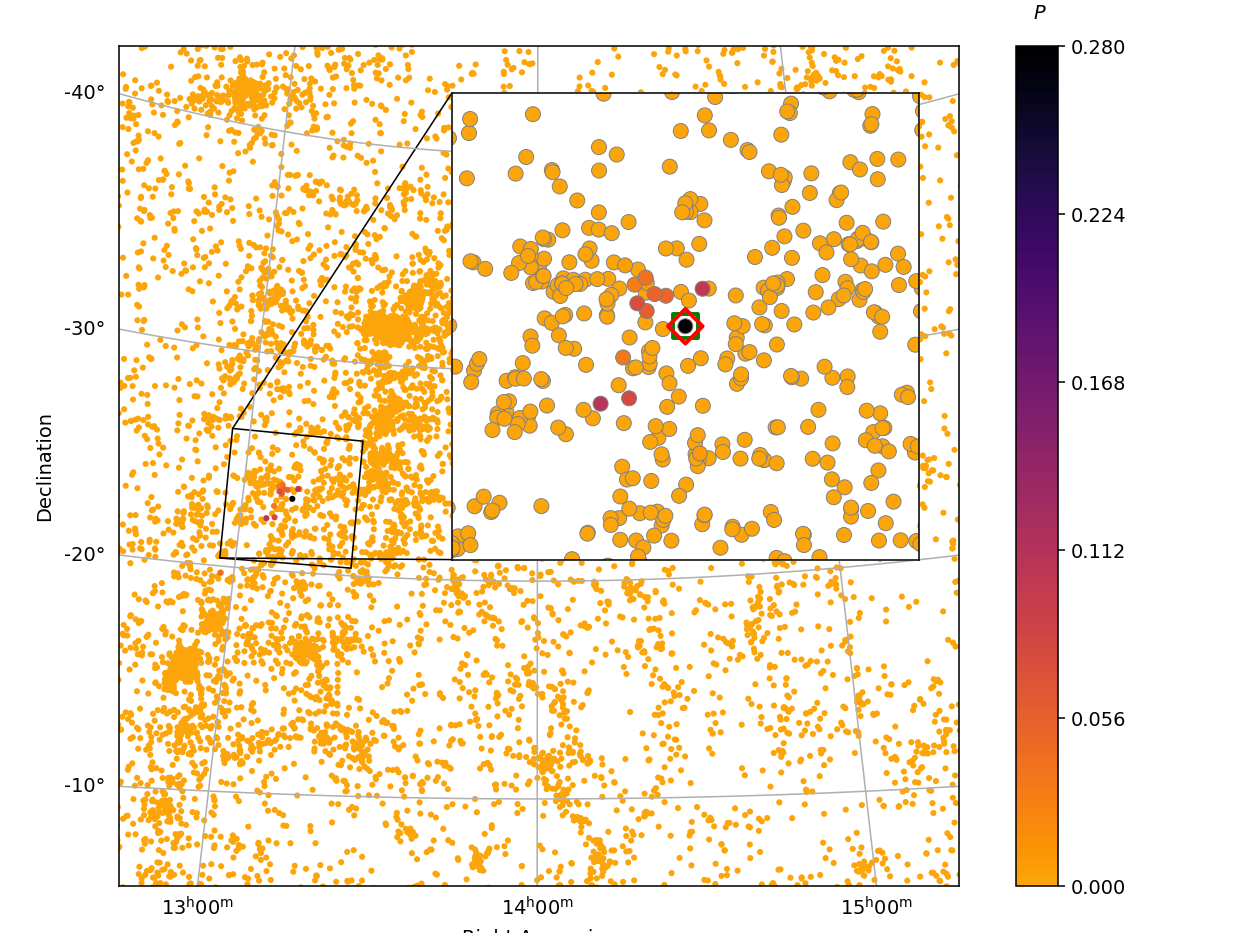

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.27995863166791

PnM*SFR proba


<IPython.core.display.Javascript object>


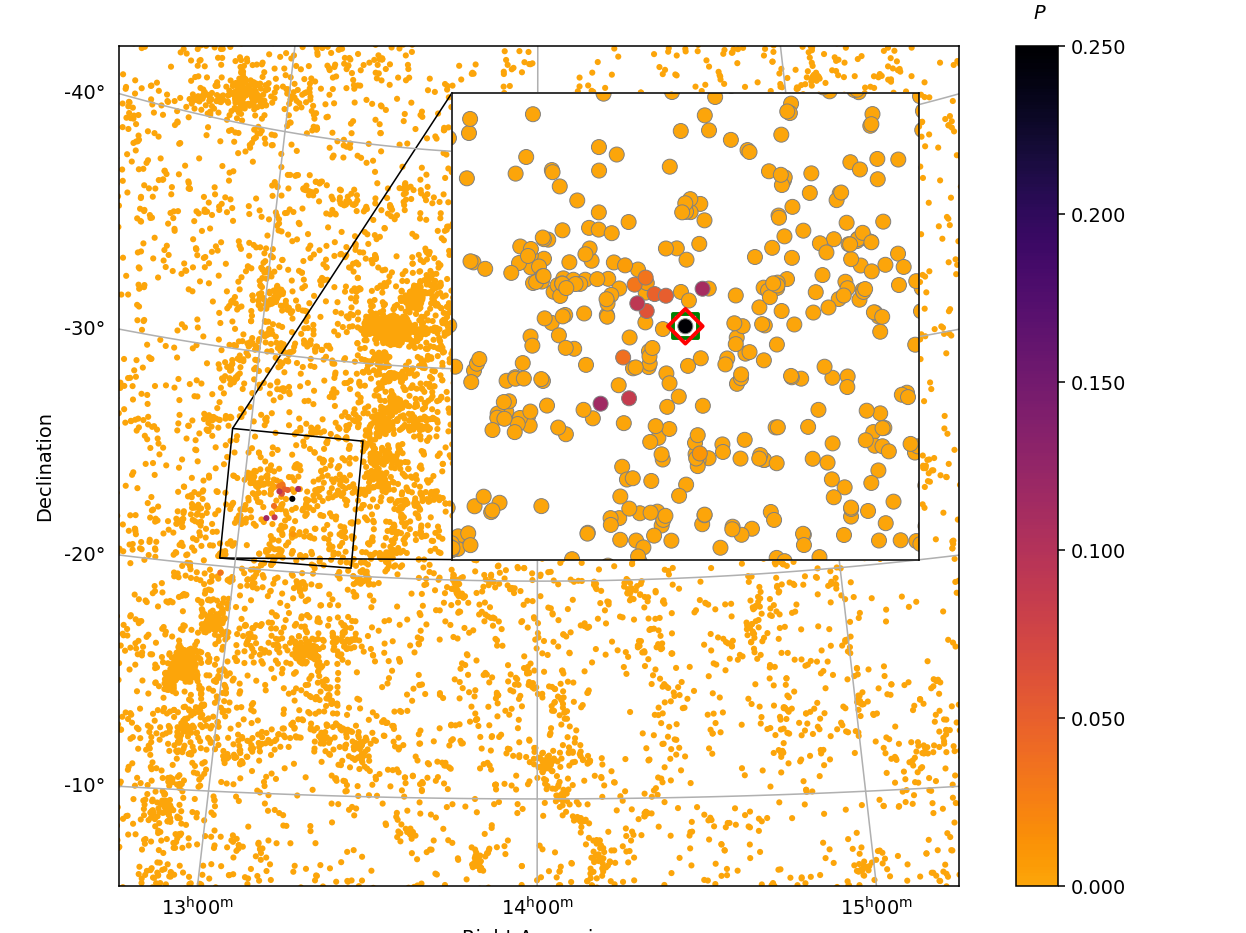

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.24999785293107346

P_final proba


<IPython.core.display.Javascript object>


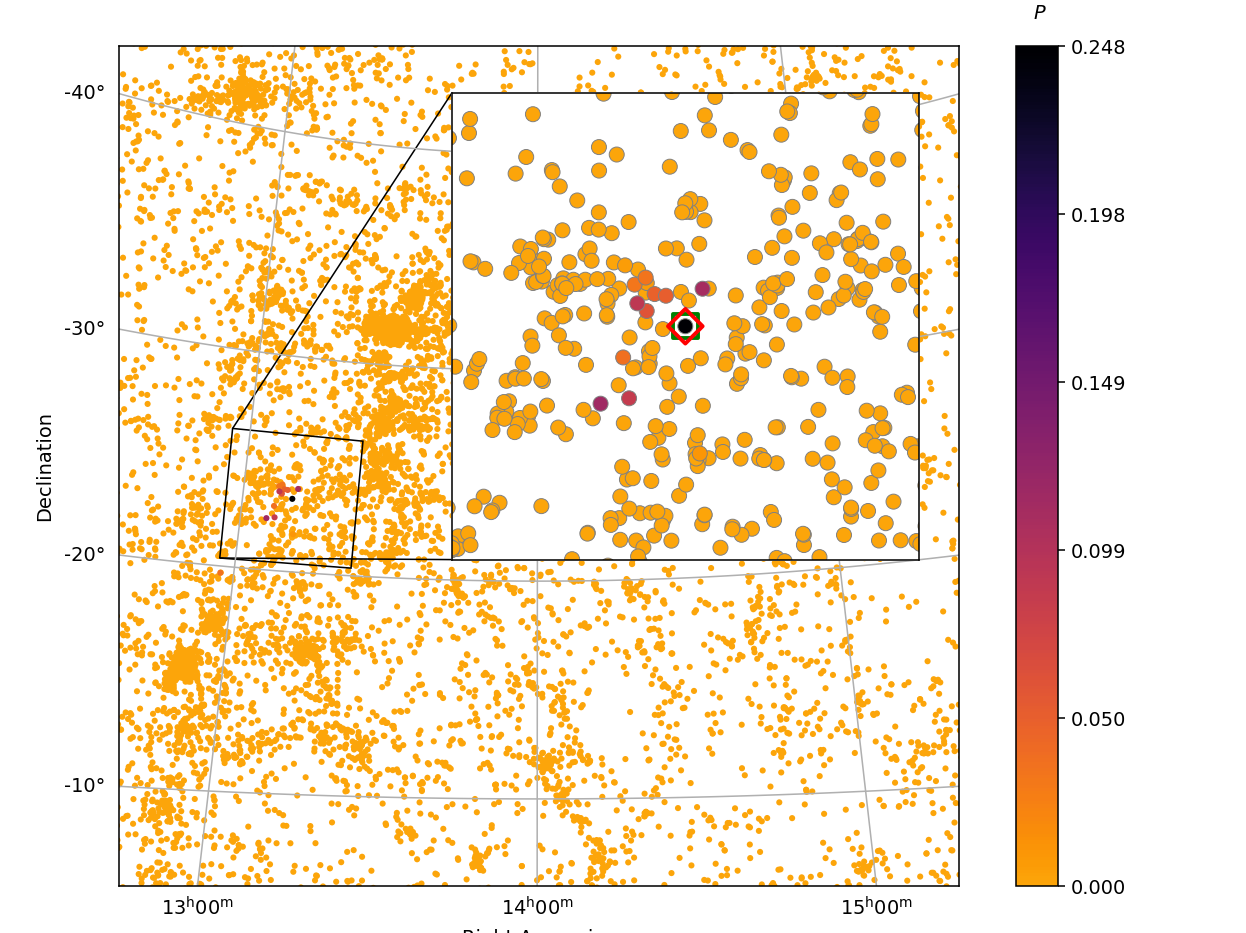

TRUE (ra,dec)=(197.449,-23.3839). BEST (ra,dec)=(197.449,-23.3839)
vmin, vmax = 0.0, 0.24760245927580468


In [21]:
true_RA = float(candidates["RA"][candidates["OBJNAME"]=="NGC4993"])
true_DEC = float(candidates["DEC"][candidates["OBJNAME"]=="NGC4993"])

RA = candidates["RA"]
DEC = candidates["DEC"]
mean_RA = np.mean(RA)
mean_DEC = np.mean(DEC)

# radius = max(max(np.abs(RA - mean_RA)) ** 2.0 + max(np.abs(DEC - mean_DEC)))
# radius = 1.1 * np.max(((RA - mean_RA) ** 2.0 + (DEC - mean_DEC) ** 2.0) ** 0.5)

### KONSTANTINOS: play with these values to center/zoom the figures
radius = 20
inset_radius = 3
rotation = 0
center_offset_ra = 1.8   # in units of radius
center_offset_dec = -1.5   # in units of radius

center=SkyCoord(mean_RA*u.deg, mean_DEC*u.deg)
center_inset = SkyCoord(true_RA*u.deg, true_DEC*u.deg)


# ax_inset.scalebar((0.1, 0.1), 1 * u.deg).label()
# ax_inset.compass(0.9, 0.1, 0.2)


# variable = np.log10(P_2d)
# variable = P_2d
# variable = P_3d
# variable = PB
# variable = PAM_Du

def plot_variable(variable, outpath=None, cblabel=True):
    plt.figure()

    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='astro zoom',
        center=SkyCoord((mean_RA + center_offset_ra*radius)*u.deg, (mean_DEC + center_offset_dec*radius)*u.deg),
        radius=radius*u.deg,
        rotate=rotation*u.deg
    )

    ax_inset = plt.axes(
        [0.3, 0.4, 0.5, 0.5],
        projection='astro zoom',
        center=center_inset,
        radius=inset_radius*u.deg,
        rotate=rotation*u.deg
    )

    for key in ['ra', 'dec']:
        ax_inset.coords[key].set_ticklabel_visible(False)
        ax_inset.coords[key].set_ticks_visible(False)
        ax.coords[key].set_ticks_visible(False)

    ax.mark_inset_axes(ax_inset)
    ax.connect_inset_axes(ax_inset, 'upper left')
    ax.connect_inset_axes(ax_inset, 'lower left')

    cmap = "inferno_r"
    # cmap = "cividis_r"
    cmin = 0.2
    cmax = 1.0
    newcolours = mpl.cm.get_cmap(cmap)(np.linspace(cmin, cmax, 256))
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    mycmap = ListedColormap(newcolours)
    cmap = mycmap

    # cmap = ListedColormap(
    #     np.array([[1-i**0.5, 0.4*(1-i**0.7), 0.2*(1-i**2.0), 1] for i in np.linspace(0, 1.0, 16)]), 
    #     "mycmap")
    # print(cmap.colors)

    for i, ax_i in enumerate([ax, ax_inset]):
        markersize= 10 if i == 0 else 60
        order = np.argsort(variable)
        which = np.isfinite(variable[order])
        best_RA = candidates["RA"][order[which][-1]]
        best_DEC = candidates["DEC"][order[which][-1]]
        color = variable[order][which]
        #### Konstantinos: where the problem was...
        ax_i.scatter(candidates["RA"][order][which].to_numpy() * u.deg, 
                     candidates["DEC"][order][which].to_numpy() * u.deg, 
                     transform=ax_i.get_transform('world'), 
                     c=color, s=markersize, 
                     cmap=cmap, ec="gray" if i==1 else "none", lw=0.5)
        if i == 1:
            print("TRUE (ra,dec)=({:.6g},{:.6g}). BEST (ra,dec)=({:.6g},{:.6g})".
                  format(true_RA, true_DEC, best_RA, best_DEC))
            ax_i.scatter(true_RA * u.deg, true_DEC * u.deg, c="none", ec="g", marker="s", lw=2, s=160, transform=ax_i.get_transform('world'))
            ax_i.scatter(best_RA * u.deg, best_DEC * u.deg, c="none", ec="r", marker="D", lw=2, s=160, transform=ax_i.get_transform('world'))
    ax.grid()
    # ax.set_ylabel("Right ascension")
    # ax.set_ylabel("Declination")
    vmin, vmax = np.nanmin(variable), np.nanmax(variable)
    vmin = 0.0
    print("vmin, vmax = {}, {}".format(vmin, vmax))
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fmt = '%.{}f'.format(max(3, 1-int(np.floor(np.log10(np.nanmax(variable))))))
    cb = plt.colorbar(sm, ax=ax, ticks=np.linspace(vmin, vmax, 6),
                     format=fmt)
    if cblabel:
        cb.set_label("$P$", labelpad=-45, y=1.05, rotation=0)
    
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    
    
    # plt.tight_layout()
#     if outpath is not None:
#         plt.savefig(outpath, bbox_inches="tight")
    plt.show()    

print("P2D proba")
plot_variable(P2D_norm, outpath="P_2D.pdf")
print("", "P3D proba",sep='\n')
plot_variable(P3D_norm, outpath="P_3D.pdf")
print("", "PnM proba",sep='\n')
plot_variable(PnM_norm, outpath="P_M.pdf")
print("", "PnM*SFR proba",sep='\n')
plot_variable(PnMSFR_norm, outpath="P_M.pdf")
print("", "P_final proba",sep='\n')
plot_variable(P_final, outpath="P_M.pdf")

# plot_variable(PB, outpath="P_B.pdf")
# plot_variable(PAMS_Du, outpath="P_A2D.pdf")
# plot_variable(PAC_Du, outpath="P_ACD.pdf")